# 1.3. Pooling

In many networks, it is desirable to gradually reduce the spatial resolution to reach
the final output. Pooling is a common operation to achieve this. Similar to convolution
pooling is a **sliding window** operation performing the pooling at all pixels.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" >

There are two major types of pooling:
* **Max** the maximum value in the kernel window is the pooled output.
* **Average** the average of all cells in the kernel window is the pooled output.

## 0. Preparation
### Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.
* [skimage](https://scikit-image.org/) is a collection of image processing algorithms.
* [request](https://requests.readthedocs.io/en/latest/) is a simple HTTP library.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import skimage
import torch

### Input image

In our example, we work with images to see the effect of convolution on them. First, we read 
two images by their URL using the `skimage.io.imread` function. Next, we visualise the images
using `matplotlibt` routines.


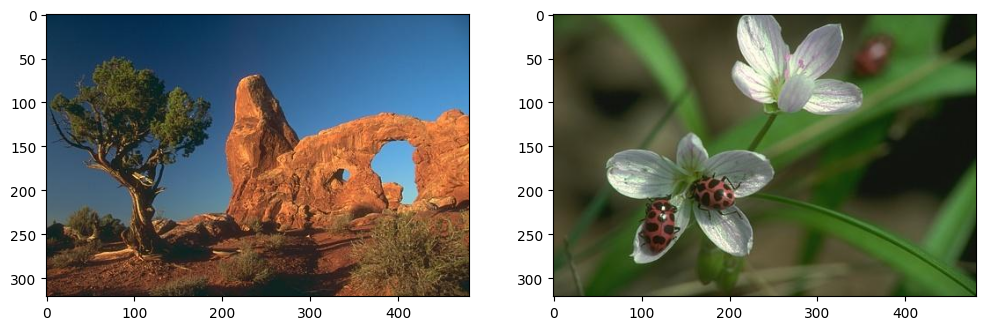

In [2]:
# URLs of the images we will load
urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg',
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/35008.jpg'
]

# Load the images using list comprehension
imgs = [skimage.io.imread(url) for url in urls]

# Visualise the two images side by side
fig = plt.figure(figsize=(12, 4))            # Create a figure with a custom size
for img_ind, img in enumerate(imgs):         # Looping through the images
    ax = fig.add_subplot(1, 2, img_ind + 1)  # Add subplots for each image
    ax.imshow(img)                           # Display the image

Our input images have spatial resolution $321 \times 481$.

In [3]:
print("Image size:", imgs[0].shape)

Image size: (321, 481, 3)


### Tensor
In this tutorial, we'll use ```torch``` as one of the frameworks that support basic operations.

```torch``` expects images in a different format, the type should be ```float``` and channels should proceed the spatial dimension, i.e., ```(3, w, h)```.

Furthermore, ```torch``` functions are designed for Tensors of 4D, where the first dimension corresponds to different images ```(b, 3, w, h)```. In our example, b equals 2 as we have loaded two images.

In [4]:
# converting the images from uint8 to float and create a torch tensor
torch_tensors = [torch.from_numpy(img.astype('float32')) / 255 for img in imgs]
# permuting the tensor to place the RGB channles as the first dimension
torch_tensors = [torch.permute(torch_tensor, (2, 0, 1)) for torch_tensor in torch_tensors]
# stacking both images into one 4D tensor
torch_tensors = torch.stack(torch_tensors, dim=0)
print("Tensor size:", torch_tensors.shape)

Tensor size: torch.Size([2, 3, 321, 481])


## 1. Max pooling

Let's perform max pooling on our input images with `kernel_size=(2, 2)`.
We can see the output resolution is halved $160 \times 240$.

In [7]:
max_pool = torch.nn.MaxPool2d(kernel_size=(2, 2))
max_out = max_pool(torch_tensors)
print(max_out.shape)

torch.Size([2, 3, 160, 240])


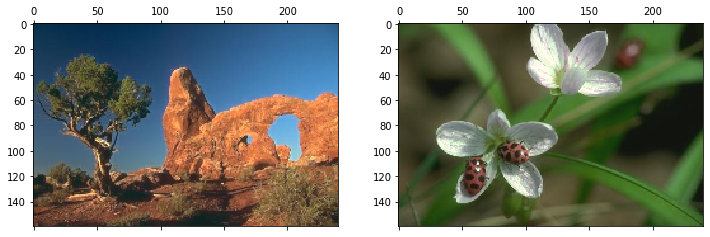

In [8]:
max_out_np = max_out.numpy()
max_out_np = np.transpose(max_out_np, (0, 2, 3, 1))

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(max_out_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.matshow(img)

Let's create a small tensor of size $4 \times 4$ to better understand the output of max pooling.

In [15]:
small_tensor = torch.randint(0, 10, (1, 1, 4, 4)).float()
print(small_tensor.squeeze())

tensor([[6., 9., 9., 2.],
        [6., 9., 6., 0.],
        [8., 3., 4., 5.],
        [9., 2., 3., 5.]])


We can see the output is a $2 \times 2$ matrix with pooled values corresponding to the maximum
values from input pixels.

In [16]:
print(max_pool(small_tensor).squeeze())

tensor([[9., 9.],
        [9., 5.]])


## 2. Average pooling

Let's perform average pooling on our input images with kernel_size=(2, 2). We can see the output resolution is halved 
.

In [17]:
avg_pool = torch.nn.AvgPool2d(kernel_size=(2, 2))
avg_out = avg_pool(torch_tensors)
print(avg_out.shape)

torch.Size([2, 3, 160, 240])


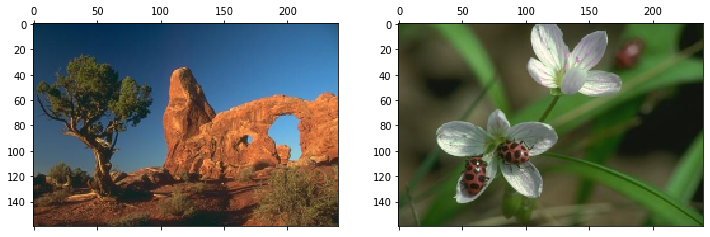

In [18]:
avg_out_np = avg_out.numpy()
avg_out_np = np.transpose(avg_out_np, (0, 2, 3, 1))

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(avg_out_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.matshow(img)

Let's compute the average pooling overrour small tensor of size $4 \times 4$.

We can see the output is a $2 \times 2$ matrix with pooled values corresponding to the average
values from input pixels.

In [20]:
print(avg_pool(small_tensor).squeeze())

tensor([[7.5000, 4.2500],
        [5.5000, 4.2500]])


## 3. Max versus average pooling

If we compare the output of max and average pooling over the small tensor, we can see big
differences:
* In the case of max pooling, three out of four pixels have the same value (9).
* The very same pixels, in average pooling result in three different numbers.


Let's visualise the difference in natural images:

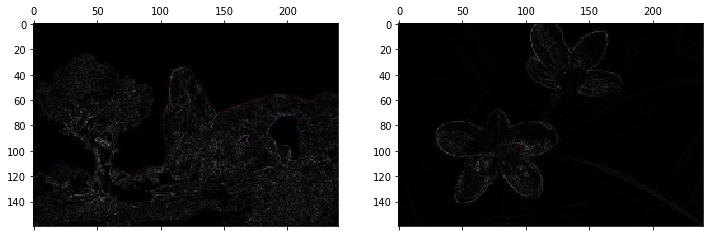

In [21]:
# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(avg_out_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.matshow(abs(img - max_out_np[img_ind]))

## 4. Global pooling

Pooling layers reduce the spatial size of feature maps.  
* With **normal pooling** (e.g., `AvgPool2d`, `MaxPool2d`), we specify the **window size**.  
* With **global pooling**, we specify the **output size**. This makes global pooling especially useful before fully connected layers, as it converts any feature map into a fixed-size vector.

Let's create a small tensor of size $4 \times 4$ to better understand the difference.

In [3]:
# Create a simple 4×4 feature map
x = torch.tensor([[[[1., 2., 3., 4.],
                    [5., 6., 7., 8.],
                    [9.,10.,11.,12.],
                    [13.,14.,15.,16.]]]])

print("Input shape:", x.shape)
print(x)

Input shape: torch.Size([1, 1, 4, 4])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])


In [5]:
# Normal pooling: specify window size
avg_pool = torch.nn.AvgPool2d(kernel_size=2)
max_pool = torch.nn.MaxPool2d(kernel_size=2)

avg_out = avg_pool(x)
max_out = max_pool(x)

print("\nAverage Pooling (2×2 window):")
print(avg_out)

print("\nMax Pooling (2×2 window):")
print(max_out)


Average Pooling (2×2 window):
tensor([[[[ 3.5000,  5.5000],
          [11.5000, 13.5000]]]])

Max Pooling (2×2 window):
tensor([[[[ 6.,  8.],
          [14., 16.]]]])


In [7]:
# Global pooling: specify output size
global_avg = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
global_max = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

gavg_out = global_avg(x)
gmax_out = global_max(x)

print("\nGlobal Average Pooling (output size = 1×1):")
print(gavg_out)

print("\nGlobal Max Pooling (output size = 1×1):")
print(gmax_out)


Global Average Pooling (output size = 1×1):
tensor([[[[8.5000]]]])

Global Max Pooling (output size = 1×1):
tensor([[[[16.]]]])
